Christabel Membere - 01703600

## A CNN Model for predicting delayed current signals

In [20]:
# Set up the environment 
import os 
!pip install numpy scipy matplotlib h5py scikit-learn
import pywt
import tensorflow as tf9o
import numpy 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

In [ ]:
def load_signals_labelled(mat_files, delay_loc_files, delay_key):
    """
        Load raw signals from .mat files and label them based on delay locations from delay_loc files.
    
        Args:
            mat_files (list): List of file paths to the .mat files containing the signals.
            delay_loc_files (list): List of file paths to the .mat files containing delay event numbers.
            delay_key (str): The key to access delay event numbers in the .mat files.
    
        Returns:
            np.ndarray: Array of all raw signals.
            np.ndarray: Array of corresponding labels (1 = delay, 0 = no delay).
        """        
    all_signals = []
    all_labels = []

    for mat_file, delay_loc_file in zip(mat_files, delay_loc_files):
      
        # Load the .mat file
        mat_contents = scipy.io.loadmat(mat_file)
        Final_array = mat_contents['Final_array']
        raw_signals = Final_array.flatten()

        # Load the delay_loc file that contains an array of the event numbers classified as delayed
        delay_contents = scipy.io.loadmat(delay_loc_file)
        delay_event_numbers = delay_contents[delay_key].flatten()

        # Initialize labels array
        labels = np.zeros(len(raw_signals))

        # Mark delay events as 1
        labels[delay_event_numbers - 1] = 1 

        # Append signals and labels to the lists
        all_signals.extend(raw_signals)
        all_labels.extend(labels)

    return np.array(all_signals), np.array(all_labels)

mat_files = [
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat', 
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array2.mat', 
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array3.mat', 
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array4.mat'
]
delay_loc_files = [
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/delay_loc_bar15-0-control',
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/delay_loc_bar15-0-10nM',
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/delay_loc_bar15-1-10nM',
    '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/delay_loc_bar15-2-10nM'
]

delay_key = 'DelayLoc_5'
    
all_signals, all_labels = load_signals_labelled(mat_files, delay_loc_files, delay_key)

In [24]:
def compute_dwt(signal, target_length=1024):
    """
    Compute the Discrete Wavelet Transform of the given signal, pad the wavelet coefficients, 
    and return a flattened array of coefficients with a fixed length.
    
    Args:
        signal (array): The input signal.
        target_length (int): The desired length of the output array is 1024.
    
    Returns:
        np.ndarray: Flattened and padded array of DWT coefficients.
    """
    # Compute wavelet decomposition coefficients
    coeffs = pywt.wavedec(signal, 'db1', level=4)
    coeffs_flat = np.hstack(coeffs)
    
    # Pad the coefficients to ensure all outputs are of the same length
    if len(coeffs_flat) < target_length:
        coeffs_flat = np.pad(coeffs_flat, (0, target_length - len(coeffs_flat)), 'constant', constant_values=np.nan)

    return coeffs_flat

target_length = 1024

dwt_images = [compute_dwt(signal, target_length) for signal in all_signals]
dwt_images = np.array(dwt_images)

# Resize the coefficients to CNN input image size
input_size = (64, 64)
dwt_images_resized = np.array([np.resize(img, input_size) for img in dwt_images])

# Convert to 3-channel grayscale
dwt_images_resized = np.stack([dwt_images_resized]*3, axis=-1)

X_train, X_test, y_train, y_test = train_test_split(dwt_images_resized, all_labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

/var/folders/kk/qpprp2511f53_78vqhc77gk00000gn/T/ipykernel_59050/909597205.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dwt_images = np.array(dwt_images)


Training data shape: (12800, 64, 64, 3)
Testing data shape: (3200, 64, 64, 3)
Training labels shape: (12800,)
Testing labels shape: (3200,)


Keys in mat file: dict_keys(['__header__', '__version__', '__globals__', 'Event', 'Final_array', 'MaxTime', 'PoisLamda', 'Pop', 'SkewGauss', 'StartLing', 'Vectors', 'i', 'numberRows', 'padded_array', 'prepad', 'thresh'])
Shape of Final_array: (1, 4000)
Loaded signal length: 1308


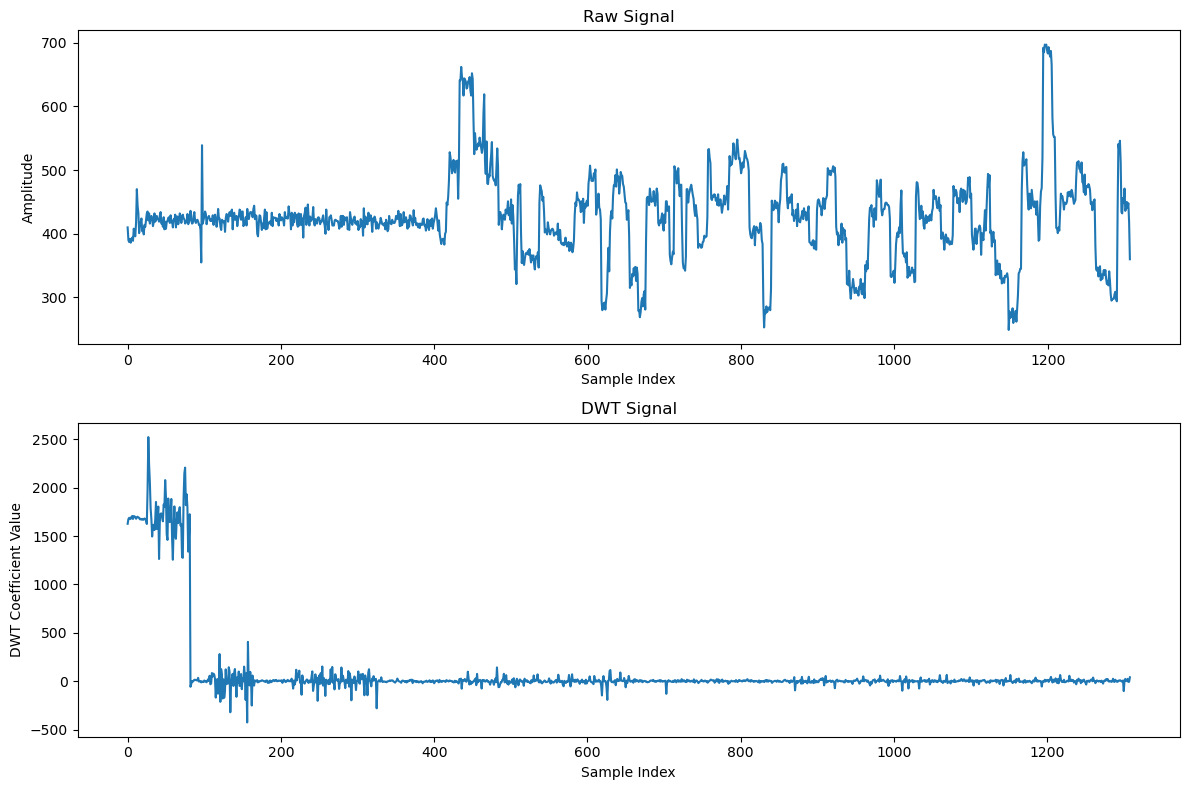

In [23]:
# Load a sample signal 
def load_sample_signal(mat_file, signal_index=0):
    mat_contents = scipy.io.loadmat(mat_file)
    print(f"Keys in mat file: {mat_contents.keys()}")
    Final_array = mat_contents['Final_array']
    print(f"Shape of Final_array: {Final_array.shape}")
    signal = Final_array[0, signal_index]  # Extracting the correct signal
    signal = signal.flatten()  # Ensure the signal is flattened
    print(f"Loaded signal length: {len(signal)}")
    return signal

# Compute the Discrete Wavelet Transform of signals
def compute_dwt(signal, target_length=1024):
    coeffs = pywt.wavedec(signal, 'db1', level=4)
    coeffs_flat = np.hstack(coeffs)
    if len(coeffs_flat) < target_length:
        coeffs_flat = np.pad(coeffs_flat, (0, target_length - len(coeffs_flat)), 'constant', constant_values=np.nan)
    return coeffs_flat

# Plot raw signal and DWT signal
def plot_signals(raw_signal, dwt_signal):
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    
    axs[0].plot(raw_signal)
    axs[0].set_title('Raw Signal')
    axs[0].set_xlabel('Sample Index')
    axs[0].set_ylabel('Amplitude')
    
    axs[1].plot(dwt_signal)
    axs[1].set_title('DWT Signal')
    axs[1].set_xlabel('Sample Index')
    axs[1].set_ylabel('DWT Coefficient Value')
    
    plt.tight_layout()
    plt.show()

# Load a sample signal from .mat file
mat_file = '/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array.mat' 
sample_signal = load_sample_signal(mat_file, signal_index=0)

# Compute DWT of the sample signal
target_length = 1024
dwt_signal = compute_dwt(sample_signal, target_length)

# Plot raw signal and DWT signal
plot_signals(sample_signal, dwt_signal)

In [21]:
def build_cnn(input_shape): 
    """
    Builds and compiles a Convolutional Neural Network (CNN) model.

    Parameters:
    - input_shape (tuple)

    Returns:
    - model (tensorflow.keras.Model): Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
            
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
input_shape = (64, 64, 3)
cnn_model = build_cnn(input_shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [7]:
#Train and evaluate the model using ROC-AUC and Log loss 

history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

#Evaluate the model
y_pred_prob = cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_prob)
log_loss_value = log_loss(y_test, y_pred_prob)

print(f'ROC AUC: {roc_auc}')
print(f'Log Loss: {log_loss_value}')

Epoch 1/20


2024-08-19 15:22:10.489483: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 99/400 [======>.......................] - ETA: 9s - loss: nan - accuracy: 0.7484

KeyboardInterrupt: 

In [8]:
# # Plot training & validation accuracy and loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [9]:
# # Load the .mat file
# mat_contents = scipy.io.loadmat('/Users/christabel/Documents/MASTERS/PROJECT/MATLAB/Final_array')
# raw_signals = mat_contents['Final_array'][0]

# # Manually set the delay event numbers (indices)
# delay_event_numbers = [0, 2, 5, 47]  # Example indices for delayed signals
# # Initialize labels
# labels = np.zeros(len(raw_signals))
# labels[delay_event_numbers] = 1  # Set delay events to 1

In [10]:
# #Function to load subset data 
# def load_signals_labelled(mat_files, delay_event_numbers):

#     all_signals = []
#     all_labels = []

#     for mat_file in mat_files:
#         mat_contents = scipy.io.loadmat(mat_file)
#         Final_array = mat_contents['Final_array']
#         raw_signals = Final_array.flatten()

#         all_signals.extend(raw_signals)

#         labels = np.zeros(raw_signals.shape[0])
#         max_index = raw_signals.shape[0] - 1
#         valid_delay_events = [i for i in delay_event_numbers if i <= max_index]
#         labels[valid_delay_events] = 1
        
#         all_labels.extend(labels)
    
#     return np.array(all_signals), np.array(all_labels)